Image processing 2 and Introduction to image registration

Today we are going to look at some image processing. We will be learning how to import images and manipulate them.


### Preparatory steps

As we saw before, Colab has its own peculiarities. So, we have a bit of different code depending on this. 

Change the content of the next cell to mention whether we are running this notebook in Colab:

In [ ]:
runningInColab = True

The testing data can be found zipped is in the folder 'TheData'. Let's download and unzip what we need.

In [ ]:
import zipfile

if runningInColab:
    # let's make a local folder called TheData
    !mkdir TheData
    # install pydicom 
    !pip install pydicom
    ## download data and extract to cloud machine
    !wget -nc https://github.com/rrr-uom-projects/MPiCRT-Imaging/raw/main/TheData/Notebook2-data.zip -O ./TheData/Notebook2-data.zip
    %matplotlib inline
else:
    %matplotlib notebook  #NOTE that if you are running jupyter in VsCode, you might need to use %matplotlib inline instead

zfile = zipfile.ZipFile('./TheData/Notebook2-data.zip', 'r')   # unzip the directory 
zfile.extractall()
for d in zfile.namelist():   # d = directory
    print('directory and files: ', d)

directory and files:  IMG-0004-00001.dcm
directory and files:  IMG-0004-00002.dcm
directory and files:  IMG-0004-00003.dcm
directory and files:  IMG-0004-00004.dcm
directory and files:  lungs.jpg
directory and files:  lungs2.jpg
directory and files:  lungs3.jpg


Now, let's load the libraries that we will need:

In [24]:
import matplotlib.pyplot as plt
from skimage import io
import numpy as np
import pydicom
from scipy.ndimage import rotate

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 12.0)

## Make the notebook use full width of display
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Loading and Processing Images
Let's implement some simple image processing filters like the ones you learnt about during the lecture.

In [7]:
lungs = io.imread("lungs.jpg", as_gray=True)
print(lungs.shape)

(569, 600)


### Window/Level

Here we are only changing how we are visualising the data, it is not transforming the data itself

1.0 0.0


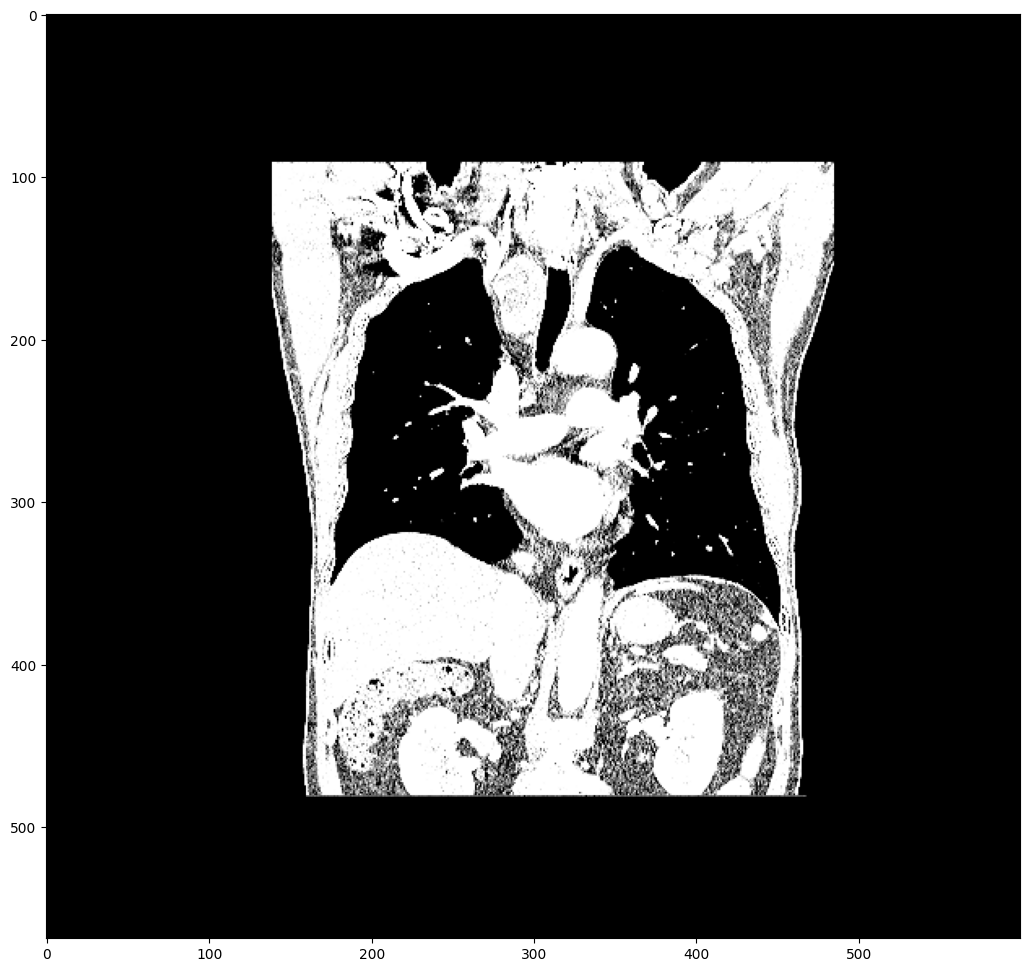

In [8]:
print(lungs.max(), lungs.min())

## Map HU to this range: 
## -1024 = 0
##  3000 = 1
## range = 4024

## From yesterdays practical, you should have figured out what bits of the 0-1 scale correspond to what structures


level = 1000/4024
window = 1000/4024

vis_min = level - window/2
vis_max = level + window/2

plt.imshow(lungs, cmap='Greys_r', vmin=vis_min, vmax=vis_max)

plt.show()



### Threshold

You can use a threshold as a simple segmentation method

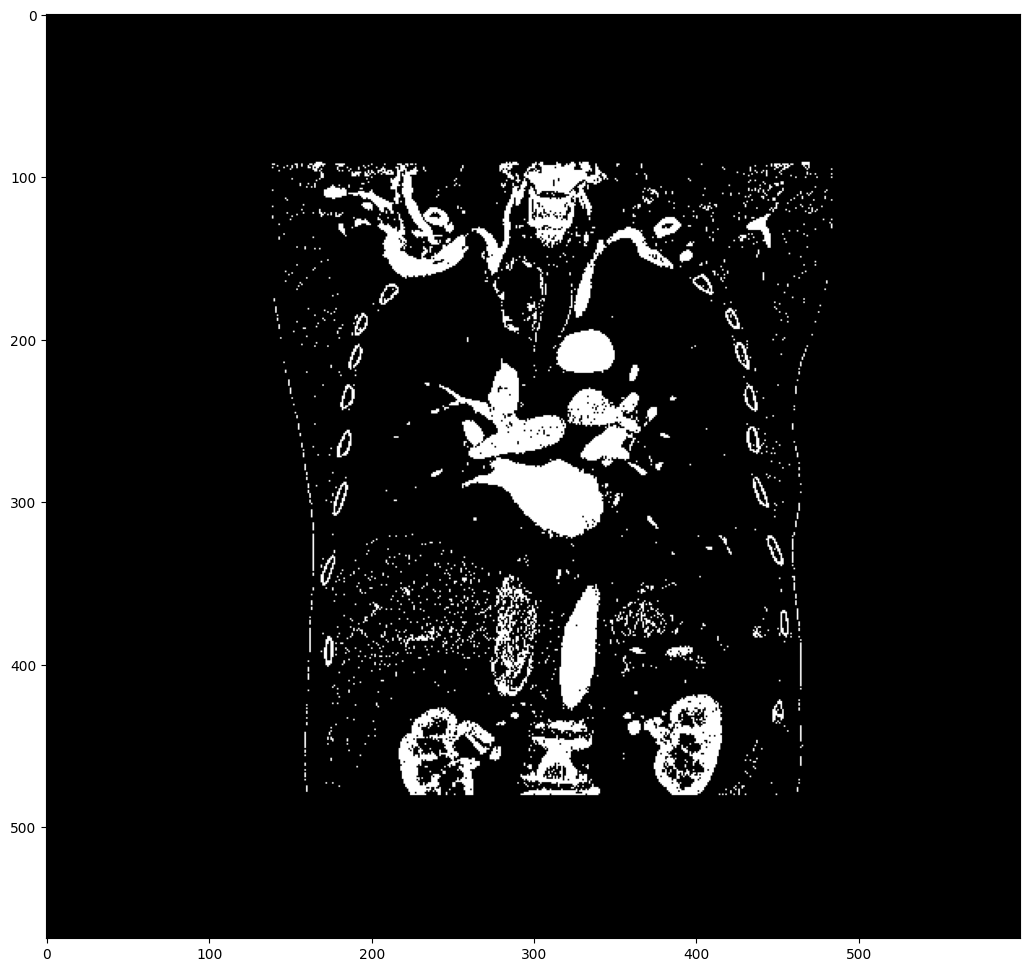

In [9]:
threshold_seg = np.zeros_like(lungs)
threshold_seg[lungs > 2000/4024] = 1 ## This is a one-sided threshold
threshold_seg[lungs < 2300/4024] = 0 ## this makes it a 'top-hat' threshold

## Try tuning this so that only muscle is selected

plt.imshow(threshold_seg, cmap='Greys_r')
plt.show()

# Interpolators

Lets take the lungs image and rotate it through 720 degrees in 10 degree steps. This ought to show how bad the interpolators are

Note, mode is about how the interpolator handles the edges, order is about how good the interpolation is, roughly:
 0 = nearest
 1 = linear
 2+ = polynomial
 
It refers to the order of the spline used in interpolation

NB this cell will take a while to run!

try playing with the number of degrees per step. How bad can you make it?

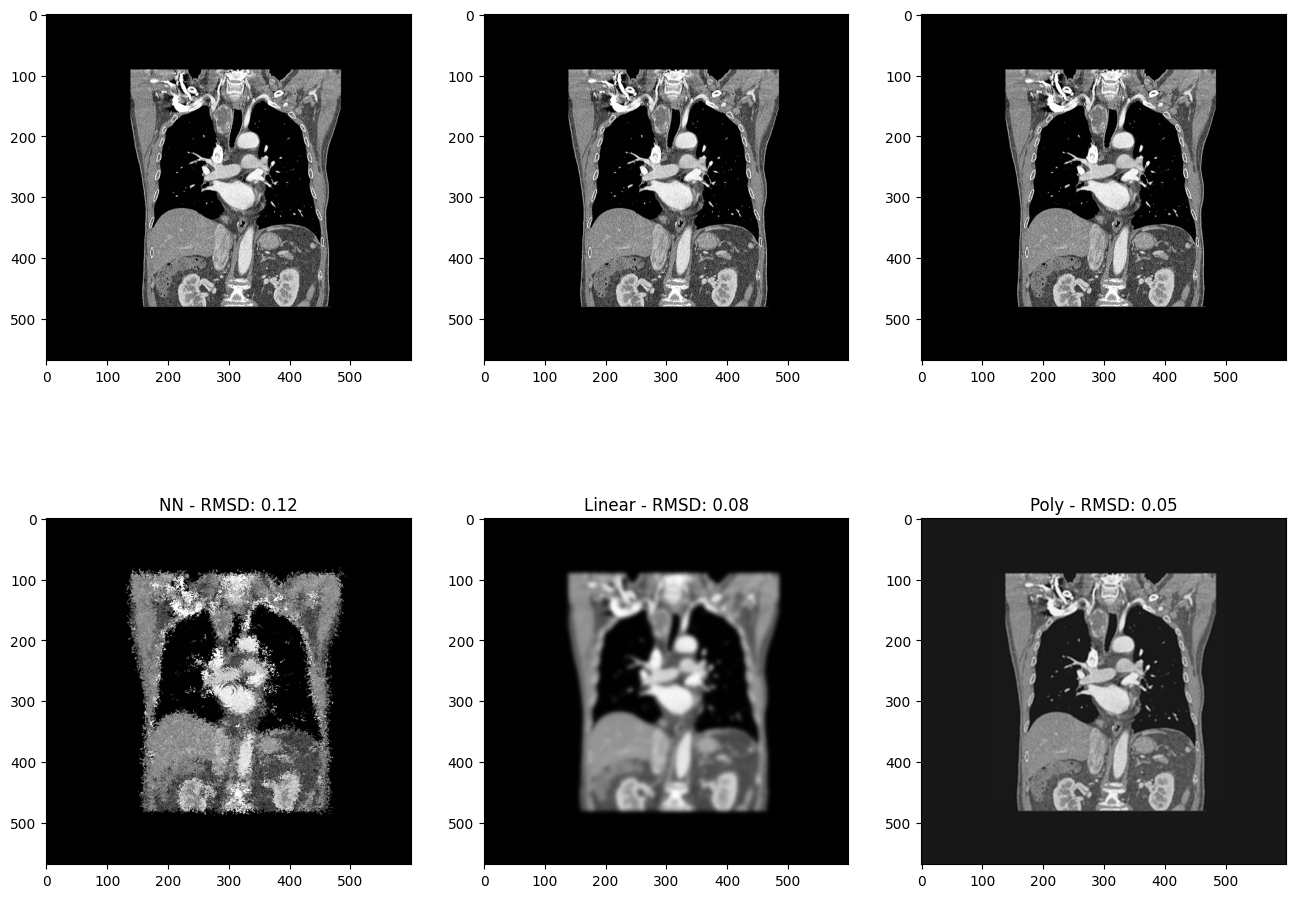

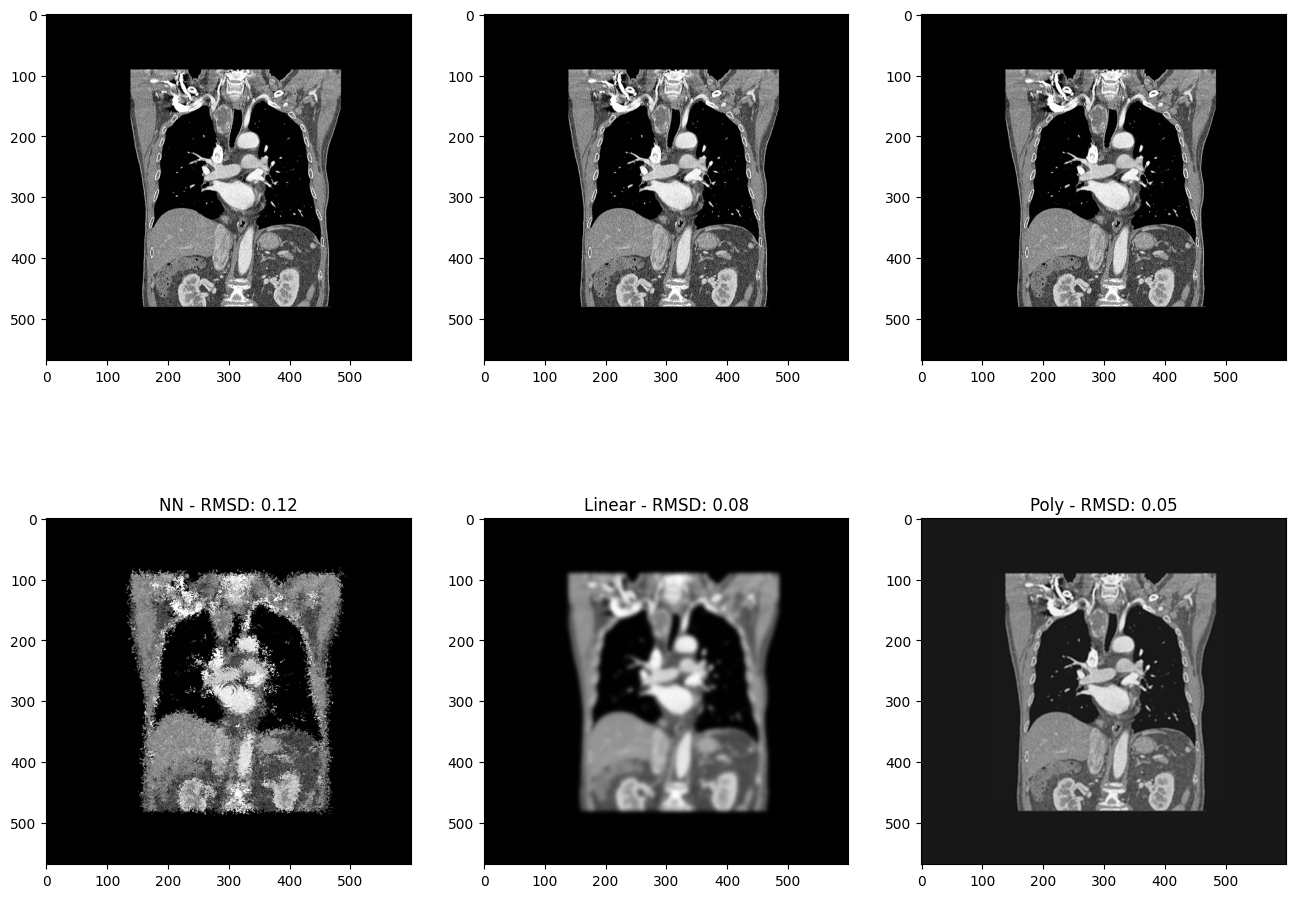

In [25]:
from IPython.display import display, clear_output
import time

fig = plt.figure()

ax0 = fig.add_subplot(231)
ax1 = fig.add_subplot(232)
ax2 = fig.add_subplot(233)

ax0.imshow(lungs, cmap='Greys_r')
ax1.imshow(lungs, cmap='Greys_r')
ax2.imshow(lungs, cmap='Greys_r')

lungs_nn = lungs.copy()
lungs_lin = lungs.copy()
lungs_poly = lungs.copy()

ax20 = fig.add_subplot(234)
ax21 = fig.add_subplot(235)
ax22 = fig.add_subplot(236)

l_nn_show = ax20.imshow(lungs_nn, cmap='Greys_r')
ax20.set_title(f"Root mean squared difference: {np.sqrt(np.mean((lungs_nn - lungs)**2)):.2f}")

l_lin_show = ax21.imshow(lungs_lin, cmap='Greys_r')
ax21.set_title(f"Root mean squared difference: {np.sqrt(np.mean((lungs_lin - lungs)**2)):.2f}")
l_poly_show = ax22.imshow(lungs_poly, cmap='Greys_r')
ax22.set_title(f"Root mean squared difference: {np.sqrt(np.mean((lungs_poly - lungs)**2)):.2f}")

degrees = 10
for i in range(72):
    print(f"{i},",end='')
    lungs_nn = rotate(lungs_nn, degrees, mode='nearest', order=0, reshape=False)
    lungs_lin = rotate(lungs_lin, degrees, mode='nearest', order=1, reshape=False)
    lungs_poly = rotate(lungs_poly, degrees, mode='nearest', order=2, reshape=False)
    
    ax20.clear()
    ax20.imshow(lungs_nn, cmap='Greys_r')
    ax20.set_title(f"NN - RMSD: {np.sqrt(np.mean((lungs_nn - lungs)**2)):.2f}")
    
    ax21.clear()
    ax21.imshow(lungs_lin, cmap='Greys_r')
    ax21.set_title(f"Linear - RMSD: {np.sqrt(np.mean((lungs_lin - lungs)**2)):.2f}")
    
    ax22.clear()
    ax22.imshow(lungs_poly, cmap='Greys_r')
    ax22.set_title(f"Poly - RMSD: {np.sqrt(np.mean((lungs_poly - lungs)**2)):.2f}")
    
    clear_output(wait=True)
    display(fig)
    time.sleep(0.1)
        
    

# DICOM

Earlier in the notebook, I imported the pydicom module, lets now use it and see how it works

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 104
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.2.3
(0002,0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.3.4
-------------------------------------------------
(0010,0010) Patient's Name                      PN: 'Lung Example'
(0028,0002) Samples per Pixel                   US: 1
(0028,0004) Photometric Interpretation          CS: 'MONOCHROME1'
(0028,0008) Number of Frames                    IS: '1'
(0028,0010) Rows                                US: 256
(0028,0011) Columns                             US: 512
(0028,0100) Bits Allocated                      US: 32
(0028,0101) Bits Stored                         US: 12
(0028,0103) Pixel Representation   

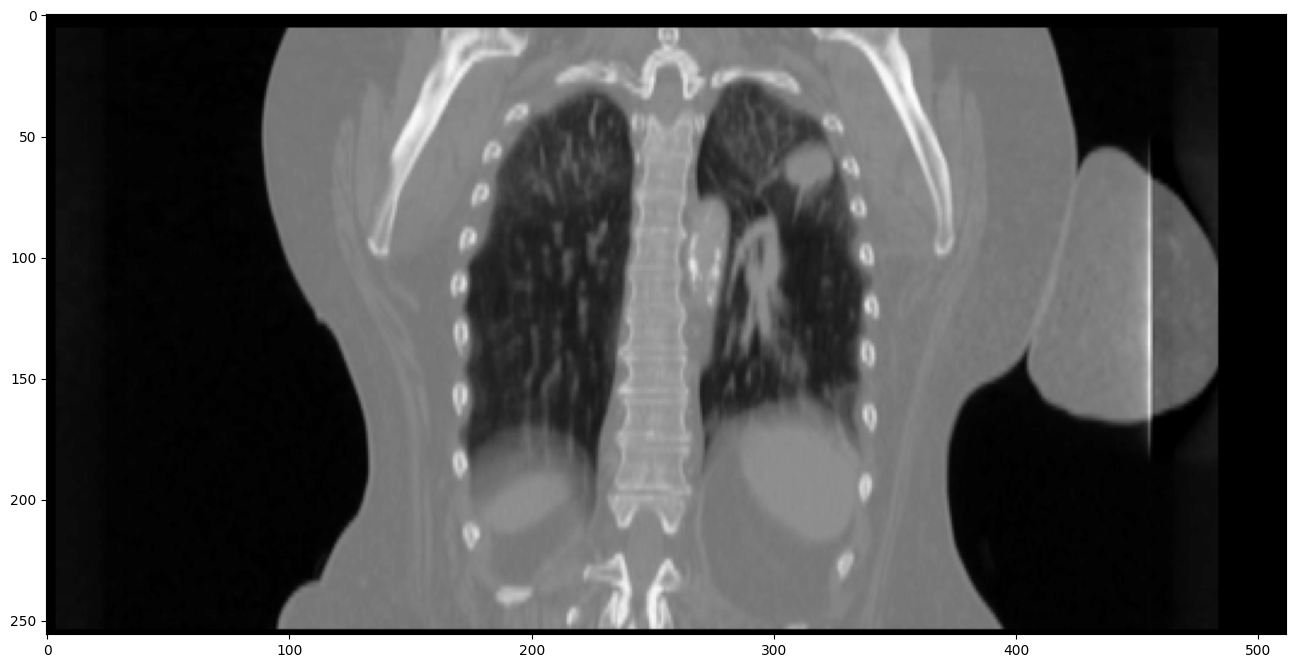

In [26]:
## There should be a file called 
patientImage = pydicom.dcmread("IMG-0004-00001.dcm")
patientImage.BitsStored = 12
print(patientImage)

fig2 = plt.figure()
ax = fig2.add_subplot(111)
ax.imshow(patientImage.pixel_array, cmap='Greys_r')
plt.show()


# Optimisers

This cell will show you how to use an optimizer for a very simple problem - finding the minimum of a function

To do this, we will use a simple optimizer in scipy, the brute force optimiser:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.brute.html

This optimiser evaluates the function on a grid of points and homes in on the best value by looking where the function is minimum. There are other, better optimizers, for example differential_evolution, which you could try.

For now, we will define a function (which is equivalent to our 'cost' function) and try to minimise it using brute. I have decided to minimise a simple quadratic with a known root, because it is easy to know if we got the right answer or not.

In the next few cells, I import the optimiser and define the function. Then I plot it over some domain, just to make sure it is doing what I think it should be

Then we use the brute force optimiser to find the root. Note the call looks like `brute(fcn, ((-10.0, 10.0),))`. The ((-10.0, 10.0),) sets the range over which it will look for solutions. One tricky detail here is that brute expects a tuple of tuples - that's why there is an extra comma.

In [27]:
from scipy.optimize import brute

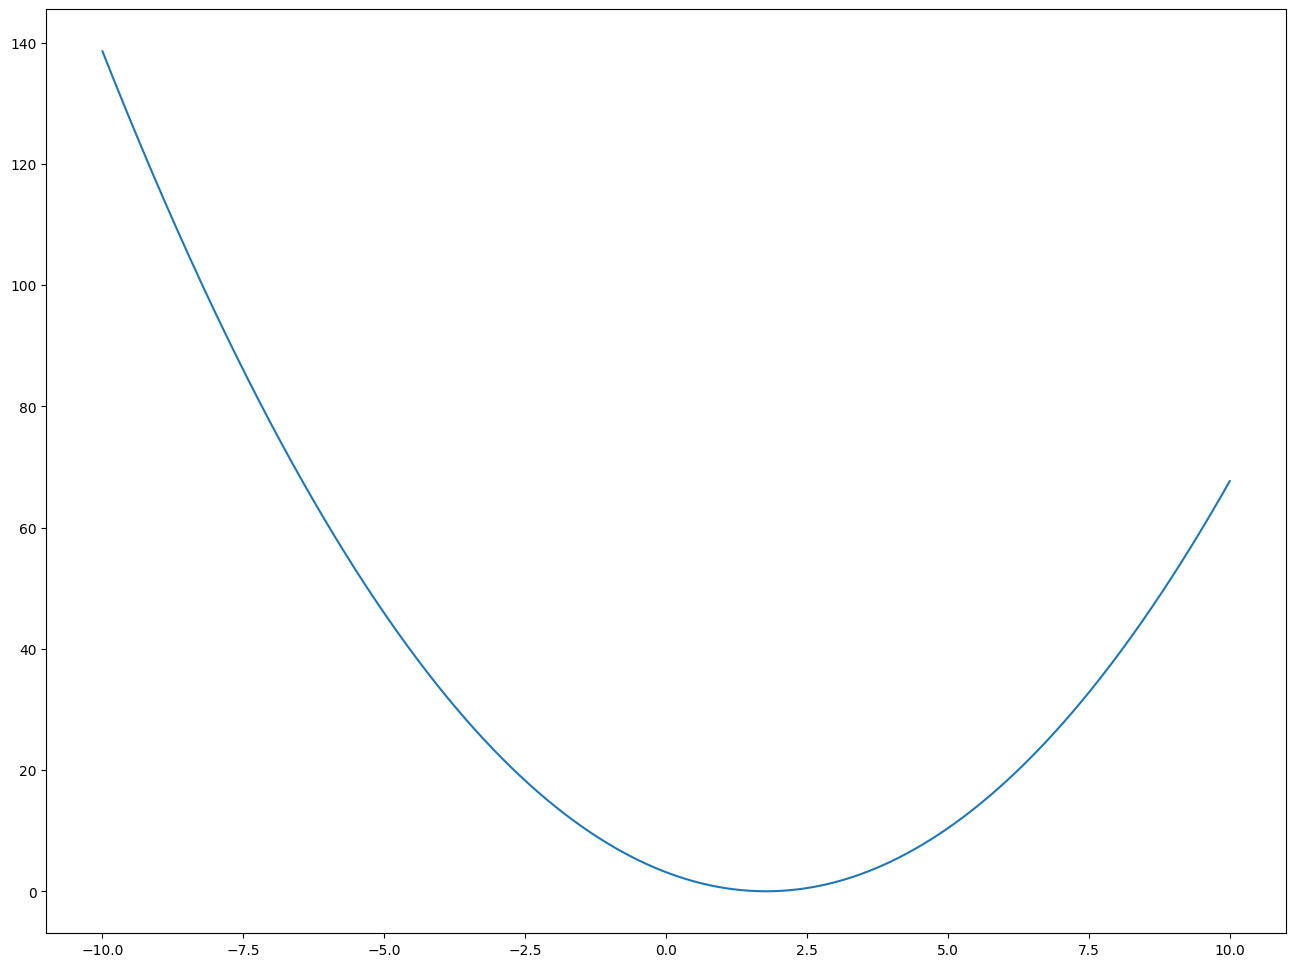

In [28]:
def fcn(x):
    return  (x  - 1.7732)**2


def fcn2(x):
    return  0.5*x*(0.5*(x  - 4)**3 - 0.5*(x-1)**2 + 7)


# let x be in the range -10 -> 10, taken at 1000 equally spaced points
domain = np.linspace(-10, 10, 1000)

domain2 = np.linspace(0, 7, 1000)

fig = plt.figure()
plt.plot(domain, fcn(domain))
plt.show()

In [29]:
## now run brute to find the minimum value

minval = brute(fcn, ((-10.0, 10.0),))

print(minval)

[1.77323191]


You should see that brute has found the root of the equation pretty accurately. Try:
    
- Changing the root. Does brute work even if it is close to the edge of the domain?
- Changing the range over which brute evaluates the function, what if it deliberately doesn't contain the root?
- Try other optimisers, e.g. differential_evolution
- Try minimizing fcn2. First plot it by doing `plt.plot(domain2, fcn2(domain2))` Do you see any problems?

## Your turn!



### Part 1

1.	Import the modules that you will need. You’ll need matplotlib.pyplot and numpy, but also imread from skimage.io, and shift and rotate from scipy.ndimage

2.	Load the images “lungs.jpg” and “lungs2.jpg”

3.	Display the images

4.	Make a plot where you can see both images on the same axes using transparency.

We will keep one of the images fixed (lungs.jpg) and make one of them able to move (lungs2.jpg). So that you can reference this moving image, specify a name for the axis when you plot it, e.g. *floating = ax.imshow(...)*

Later you can use *floating.set_data(...)* to update the image in these axes to something else (like the image after we have manipulated it)

5.	Write a function that shifts your second image given an input argument called shifts which is a list of shifts horizontally and vertically. When your function is called, the command *shiftImage(im,(10,20))* should shift the image down 10 pixels and to the right 20 pixels.

If you called the axes showing the second image “floating”, then the figure will be updated with the second to last line.

The last line will update the figure if it is already displayed.

6.	Evaluate your function by calling it. 

7.	What are the shifts needed to align the images? Make a note of them in some comments.

8.	Modify your code to include rotations. Load “lungs3.jpg” and use that as your floating image instead. What are the shifts/rotations required to align the images now?

Here is a solution to this activity up to point 7.

In [ ]:
# title
# name

# imports
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.transform import resize
from scipy.ndimage import shift

def shiftImage(im,shifts):
    # your code here…
    print(im.shape)
    shifted_image = shift(im, shifts, mode="nearest")
    floating.set_data(shifted_image)
    fig.canvas.draw()
    return shifted_image

im_lung1 = io.imread("lungs.jpg", as_gray=True)
im_lung2 = io.imread("lungs2.jpg", as_gray=True)

fig = plt.figure()

ax = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax.imshow(im_lung1,cmap="Greys_r")
floating = ax2.imshow(im_lung2,cmap="Greys_r")

shifted_image = shiftImage(im_lung2,(-20,-40))

ax3.imshow(im_lung1, cmap="viridis_r")
ax3.imshow(im_lung2, alpha=0.5,cmap="Greys_r")

ax4.imshow(im_lung1, cmap="viridis_r")
ax4.imshow(shifted_image, alpha=0.5,cmap="Greys_r")


### Part 2 
I.	Load the images “IMG-0004-00001.dcm” and “IMG-0004-00002.dcm”. get the pixel data from the dicom file as a numpy array using *img1_array = img1_dcm.pixel_array*

II.	Display the images using transparency so that you can see they are not registered. 

III. You wrote a function called shiftImage, that took a shift as a list and applied it to a global copy of an image. Copy-paste that function into your new script. Make sure:

- The image to which we will apply the shifts is an argument 
- Remove any plot-updating code
- Make the function return the image after it has been shifted

Evaluate your function by trial and error guessing the required shift that registers the first two images.